<a href="https://colab.research.google.com/github/JaiVR/suttmltask_1/blob/main/suttml_task1_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
dataset= pd.read_csv('sutt.csv')

In [4]:
#fixing the casing issues in club/dept. column
def replace_value(value):
    if value == 's':
        return 'sutt'
    elif value == 'd' or value == 'v':
        return 'dvm'
    elif value == 'g':
        return 'gaming club'
    elif value == 'm':
        return 'mountaineering club'
    else:
        return value


dataset[' CLUB / DEPARTMENT'] = dataset[' CLUB / DEPARTMENT'].str.lower().str[0].apply(replace_value)

In [5]:
X = dataset.drop(['BIRTHDAY', 'DAYS SINCE LAST SHOWER', 'TREATS GIVEN','PIZZERIA EXPENDITURE (annual)', 'GPL'], axis=1)
#y --> dependent variable
y = dataset['GPL']

In [6]:
#encoding the categorical data using one hot encoding
#independent variable
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

dataset[' CLUB / DEPARTMENT'].replace('', 'NA', inplace=True)

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['SEX', 'ADMISSION MODE', ' CLUB / DEPARTMENT', 'BOARD STUDIED', ' HAS A S/O ?', 'ATTENDS LECTURES','CHARACTER'])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [7]:
#taking care of missing values
#this code replaces the missing value with the mean of that particular column

columns_to_impute = [1,3,4,10]
X[:, columns_to_impute] = X[:, columns_to_impute].astype(float)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
imputer.fit(X[:, columns_to_impute])
X[:, columns_to_impute] = imputer.transform(X[:, columns_to_impute])

In [8]:
#encoding dependent variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
#splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [10]:
from sklearn.preprocessing import MinMaxScaler

columns_to_norm = [1,3,4,10]
scaler = MinMaxScaler()
X_train[:, columns_to_norm] = scaler.fit_transform(X_train[:, columns_to_norm])
X_test[:, columns_to_norm] = scaler.transform(X_test[:, columns_to_norm])
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [11]:
print(y_train)

[0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0
 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1
 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0
 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1
 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1
 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 

converting X and y to tensors

In [12]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [13]:
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [14]:
class Model(nn.Module):
    def __init__(self, in_features, h1=32, h2=16, h3=8, h4=4, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        x = self.sigmoid(x)
        return x

In [15]:
#pick a manual seed
torch.manual_seed(70)
in_features=X_train.shape[1]
model = Model(in_features)

In [16]:
#criterion of model to measure the error
criterion = nn.CrossEntropyLoss()
#choosing adam optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(),lr= 0.001)

In [17]:
epochs = 100
losses = []
for i in range(epochs):
  y_pred = model.forward(torch.nan_to_num(X_train)).squeeze(1)
  # print(y_pred)
  #measure the loss/error
  loss = criterion(y_train,y_pred)
  losses.append(loss.detach().numpy())

  #print every 10 epoch
  if i % 10 == 0:
    print(f'Epoch:{i} and loss:{loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch:0 and loss:2425.76611328125
Epoch:10 and loss:2138.16357421875
Epoch:20 and loss:1727.9095458984375
Epoch:30 and loss:1113.599853515625
Epoch:40 and loss:440.90283203125
Epoch:50 and loss:113.4611587524414
Epoch:60 and loss:32.87535858154297
Epoch:70 and loss:14.360758781433105
Epoch:80 and loss:8.277453422546387
Epoch:90 and loss:5.368133544921875


Text(0.5, 0, 'epochs')

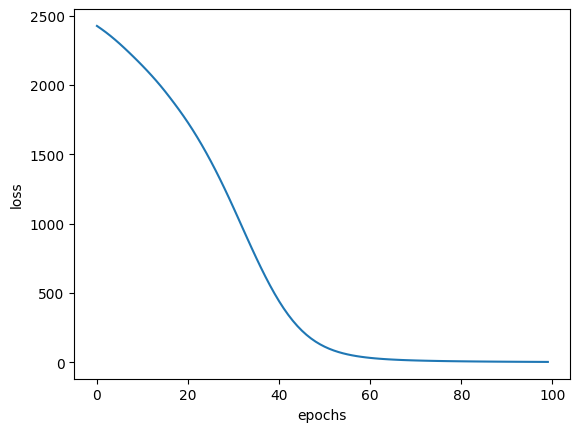

In [18]:
plt.plot(range(epochs),losses)
plt.ylabel("loss")
plt.xlabel("epochs")

In [19]:
with torch.no_grad():
  y_eval = model.forward(torch.nan_to_num(X_test)).squeeze(1)
  loss = criterion(y_eval,y_test)

In [20]:
loss

tensor(490.8049)

In [44]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, accuracy_score

correct = 0
total = 0
predictions = []

with torch.no_grad():
    for i, data in enumerate(torch.nan_to_num(X_test)):
        y_pred = model.forward(data)
        y_pred_roundoff = np.where(np.array(y_pred) > 0.5, 1, 0)
        predictions.append(y_pred_roundoff)

predictions = np.concatenate(predictions)

cm = confusion_matrix(y_test, predictions)
print(cm)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy {accuracy}')


[[129   0]
 [ 91   0]]
Accuracy 0.5863636363636363


In [22]:
seniors = pd.read_csv('seniors.csv')

In [23]:
seniors.head()

,NAME,SEX,AGES,ADMISSION MODE,CGPA - 1,CGPA-2,CLUB / DEPARTMENT,BOARD STUDIED,DAYS SINCE LAST SHOWER,BIRTHDAY,TREATS GIVEN,HAS A S/O ?,ATTENDS LECTURES,CHARACTER,PIZZERIA EXPENDITURE (annual),GRAMS / MONTH
0,Vaasu,female,18,BOARD TOPPER,3.24,4,SUTT,CBSE,14,9/15/2006,0,NO,YES,GHOT,20898,2.5
1,Rajat,male,19,BITSAT,6.45,6,SUTT,CBSE,8,7/23/2005,1,YES,YES,LITE,11695,5.7
2,Akhil,male,16,BITSAT,6.23,7,SUTT,CBSE,10,4/10/2007,3,NO,NO,LITE,16116,22.0
3,Yash,male,17,BITSAT,8.43,10,SUTT,CBSE,4,7/18/2007,4,NO,YES,LITE,13938,0.8
4,Yashwardhan,male,17,BITSAT,3.76,6,SUTT,CBSE,13,7/13/2007,3,YES,YES,LITE,18635,5.4


In [24]:
X_sen = seniors.drop(['BIRTHDAY', 'DAYS SINCE LAST SHOWER', 'TREATS GIVEN','PIZZERIA EXPENDITURE (annual)', 'NAME'], axis=1)

In [25]:
#encoding the categorical data using one hot encoding
#independent variable
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# dataset[' CLUB / DEPARTMENT'].replace('', 'NA', inplace=True)

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['SEX', 'ADMISSION MODE', ' CLUB / DEPARTMENT', 'BOARD STUDIED', ' HAS A S/O ?', 'ATTENDS LECTURES','CHARACTER'])], remainder='passthrough')
X_sen = np.array(ct.fit_transform(X_sen))

In [26]:
from sklearn.preprocessing import MinMaxScaler

columns_to_norm = [1,3,4,10]
scaler = MinMaxScaler()
X_sen[:, columns_to_norm] = scaler.fit_transform(X_sen[:, columns_to_norm])
X_sen = X_sen.astype(np.float32)

In [27]:
X_sen = torch.FloatTensor(X_sen)

In [28]:
torch.manual_seed(70)
in_features_sen=X_sen.shape[1]
model_sen = Model(in_features_sen)

In [29]:
with torch.no_grad():
    for i, data in enumerate((X_sen)):
        y_pred = model_sen.forward(data)
        if y_pred < 0.5:
            print(0)
        else:
          print(1)


0
0
0
0
0
0
0
0
0
0
0


In [30]:
rand_test = pd.read_csv('randtest.csv')

In [31]:
X_rand = rand_test.drop(['BIRTHDAY', 'DAYS SINCE LAST SHOWER', 'TREATS GIVEN','PIZZERIA EXPENDITURE (annual)'], axis=1)

In [32]:
#encoding the categorical data using one hot encoding
#independent variable
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# dataset[' CLUB / DEPARTMENT'].replace('', 'NA', inplace=True)

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['SEX', 'ADMISSION MODE', ' CLUB / DEPARTMENT', 'BOARD STUDIED', ' HAS A S/O ?', 'ATTENDS LECTURES','CHARACTER'])], remainder='passthrough')
X_rand = np.array(ct.fit_transform(X_rand))

In [33]:
from sklearn.preprocessing import MinMaxScaler

columns_to_norm = [1,3,4,10]
scaler = MinMaxScaler()
X_rand[:, columns_to_norm] = scaler.fit_transform(X_rand[:, columns_to_norm])
X_rand = X_rand.astype(np.float32)

In [34]:
X_rand = torch.FloatTensor(X_rand)

In [35]:
torch.manual_seed(70)
in_features_rand=X_rand.shape[1]
model_sen = Model(in_features_rand)

In [36]:
indexes_of_no = []
with torch.no_grad():
    for i, data in enumerate((X_rand)):
        y_pred = model_sen.forward(data)
        if y_pred < 0.5:
            print('NO')
            indexes_of_no.append(i)
        else:
          print('YES')
print("Indexes of 'NO':", indexes_of_no)

YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
NO
YES
YES
YES
YES
YES
Indexes of 'NO': [194]


In [37]:
import csv

submission = [['X_rand', 'y_pred']]
for i in range(len(y_pred)):
    submission.append([X_rand[i], y_pred[i]])

# Writing to CSV
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(submission)


In [38]:
with open('randtest_pred.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)

In [39]:
with open('randtest_pred.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['X_rand', 'y_pred']
['tensor([ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,\n         1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,\n         1.0000,  0.0000,  1.0000, 23.0000,  8.6000,  8.0000,  9.6000])', 'tensor(0.5353)']
